# Vaihe 1

### Kiinnostavat tutkimuskysymykset
1. Mitkä genret ovat olleet suosittuja milloin?
2. Mikä näyttelijöiden yhdistelmä tuottaa suosittuja elokuvia?
3. Korrelaatio arvioiden ja tuoton välillä. Voiko elokuva olla huonosti arvioitu mutta silti tuottoisa tai toisin päin?
4. Jos tekisimme elokuvan, millainen sen kannattaa olla, että se on tuottoisa ja suosittu?

# Vaihe 2

### Aineiston kuvaus
Aineisto löydettiin Kagglesta ja se sisältää tietoa elokuvista IMDB palvelussa.

Linkki aineistoon: [LINKKI](https://www.kaggle.com/datasets/ashpalsingh1525/imdb-movies-dataset)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# set display options
pd.set_option('display.max_colwidth', None)

dataset = pd.read_csv('Datasets/imdb_movies.csv')

# TODO: Fixaa tää silleen et selitetään otsikoiden tarkoitus
# Print dataframe columns
print("Aineiston otsikot:")
print(dataset.columns)
print("Otsikoiden tyypit:")
print(dataset.dtypes)
print("Aineiston muoto:")
print(dataset.shape)
amount_of_rows_pre = dataset.shape[0]


Aineiston otsikot:
Index(['names', 'date_x', 'score', 'genre', 'overview', 'crew', 'orig_title',
       'status', 'orig_lang', 'budget_x', 'revenue', 'country'],
      dtype='object')
Otsikoiden tyypit:
names          object
date_x         object
score         float64
genre          object
overview       object
crew           object
orig_title     object
status         object
orig_lang      object
budget_x      float64
revenue       float64
country        object
dtype: object
Aineiston muoto:
(10178, 12)


#### Aineiston otsikot:
- names:        Elokuvan nimi englanniksi
- date_x:       Elokuvan julkaisupäivämäärä
- score:        IMDB-käyttäjien antaman pistemäärän keskiarvo 
- genre:        Elokuvan genre
- overview:     Elokuvan kuvaus englanniksi
- crew:         Elokuvan näyttelijät ja heidän esittämät hahmot. esim. (näyttelijä, hahmo, näyttelijä, hahmo)
- orig_title:   Elokuvan nimi alkuperäisellä kielellä
- status:       Elokuvan tilanne. (Kaikki havainnot ovat julkaistu)
- orig_lang:    Elokuvan alkuperäiskieli
- budget_x:     Elokuvan budjetti (USD)
- revenue:      Elokuvan bruttotuotto (USD)
- country:      Elokuvan julkaisumaa

Aineistossa on siis 12 otsikkoa ja 10178 havaintoa.


Osa aineiston datasta on epäilyttävää. Esimerkiksi 144 elokuvista on saanut 0.0 arvostelun, ja niiden kaikkien tuotto on tasan $175,269,998.80

Aineiston julkaisija on ilmeisesti käyttänyt jotain knn keinoa aineiston täyttämiseen. Tämä täytyy ottaa huomioon myöhemmin.



# Vaihe 3
## Aineiston esikäsittely

#### Huonojen havaintojen poisto

In [9]:
# Tässä poistetaan ne havainnot joissa on tyhjiä arvoja tai arvostelu on 0.0
dataset = dataset.dropna()
dataset = dataset[dataset['score'] != 0.0]
print(dataset.shape)
amount_of_rows_post = dataset.shape[0]
print("Poistettu " + str(amount_of_rows_pre - amount_of_rows_post) + " riviä, jossa oli tyhjiä arvoja tai arvostelu oli 0.0")

(9889, 12)
Poistettu 289 riviä, jossa oli tyhjiä arvoja tai arvostelu oli 0.0


#### Avataan näyttelijät
Emme ole kiinnostuneita näyttelijöiden hahmoista, joten poistetaan ne aineistosta.

In [10]:
print("1. elokuvan näyttelijät:")
print(dataset['crew'].head(1))

1. elokuvan näyttelijät:
0    Michael B. Jordan, Adonis Creed, Tessa Thompson, Bianca Taylor, Jonathan Majors, Damien Anderson, Wood Harris, Tony 'Little Duke' Evers, Phylicia Rashād, Mary Anne Creed, Mila Davis-Kent, Amara Creed, Florian Munteanu, Viktor Drago, José Benavidez Jr., Felix Chavez, Selenis Leyva, Laura Chavez
Name: crew, dtype: object


In [11]:
# Tässä avataan näyttelijät. Näyttelijän hahmo on listattu näyttelijän jälkeen. (esim. Tom Cruise, Ethan Hunt, ...)
dataset['crew'] = dataset['crew'].str.split(', ')
# Poista joka toinen alkio
dataset['crew'] = dataset['crew'].apply(lambda x: x[::2])
print("1. elokuvan näyttelijät:")
print(dataset['crew'].head(1))

1. elokuvan näyttelijät:
0    [Michael B. Jordan, Tessa Thompson, Jonathan Majors, Wood Harris, Phylicia Rashād, Mila Davis-Kent, Florian Munteanu, José Benavidez Jr., Selenis Leyva]
Name: crew, dtype: object


Crew -sarake sisältää siis nyt vain näyttelijät ilman hahmoja

# Vaihe 4
### Aineiston analysointi

In [12]:
#  JOKAISESSA ANALYSOINTIKOHDASSA TEHDÄÄN AINEISTOSTA KOPIO, ETTEI MYÖHEMMÄT KOHDAT MUUTU

#### Mitkä genret ovat suosittuja milloin

Found 19 unique genres
   year  Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  \
0  2023       1          0          0       0      0            0      1   
1  2022       1          1          0       0      0            0      0   
2  2023       0          1          1       1      0            0      0   
3  2023       0          1          1       1      0            0      0   
4  2023       1          0          0       0      0            0      0   

   Family  Fantasy  History  Horror  Music  Mystery  Romance  Science Fiction  \
0       0        0        0       0      0        0        0                0   
1       0        0        0       0      0        0        0                1   
2       1        1        0       0      0        0        0                0   
3       1        1        0       0      0        0        0                0   
4       0        0        0       0      0        0        0                0   

   TV Movie  Thriller  War  Weste

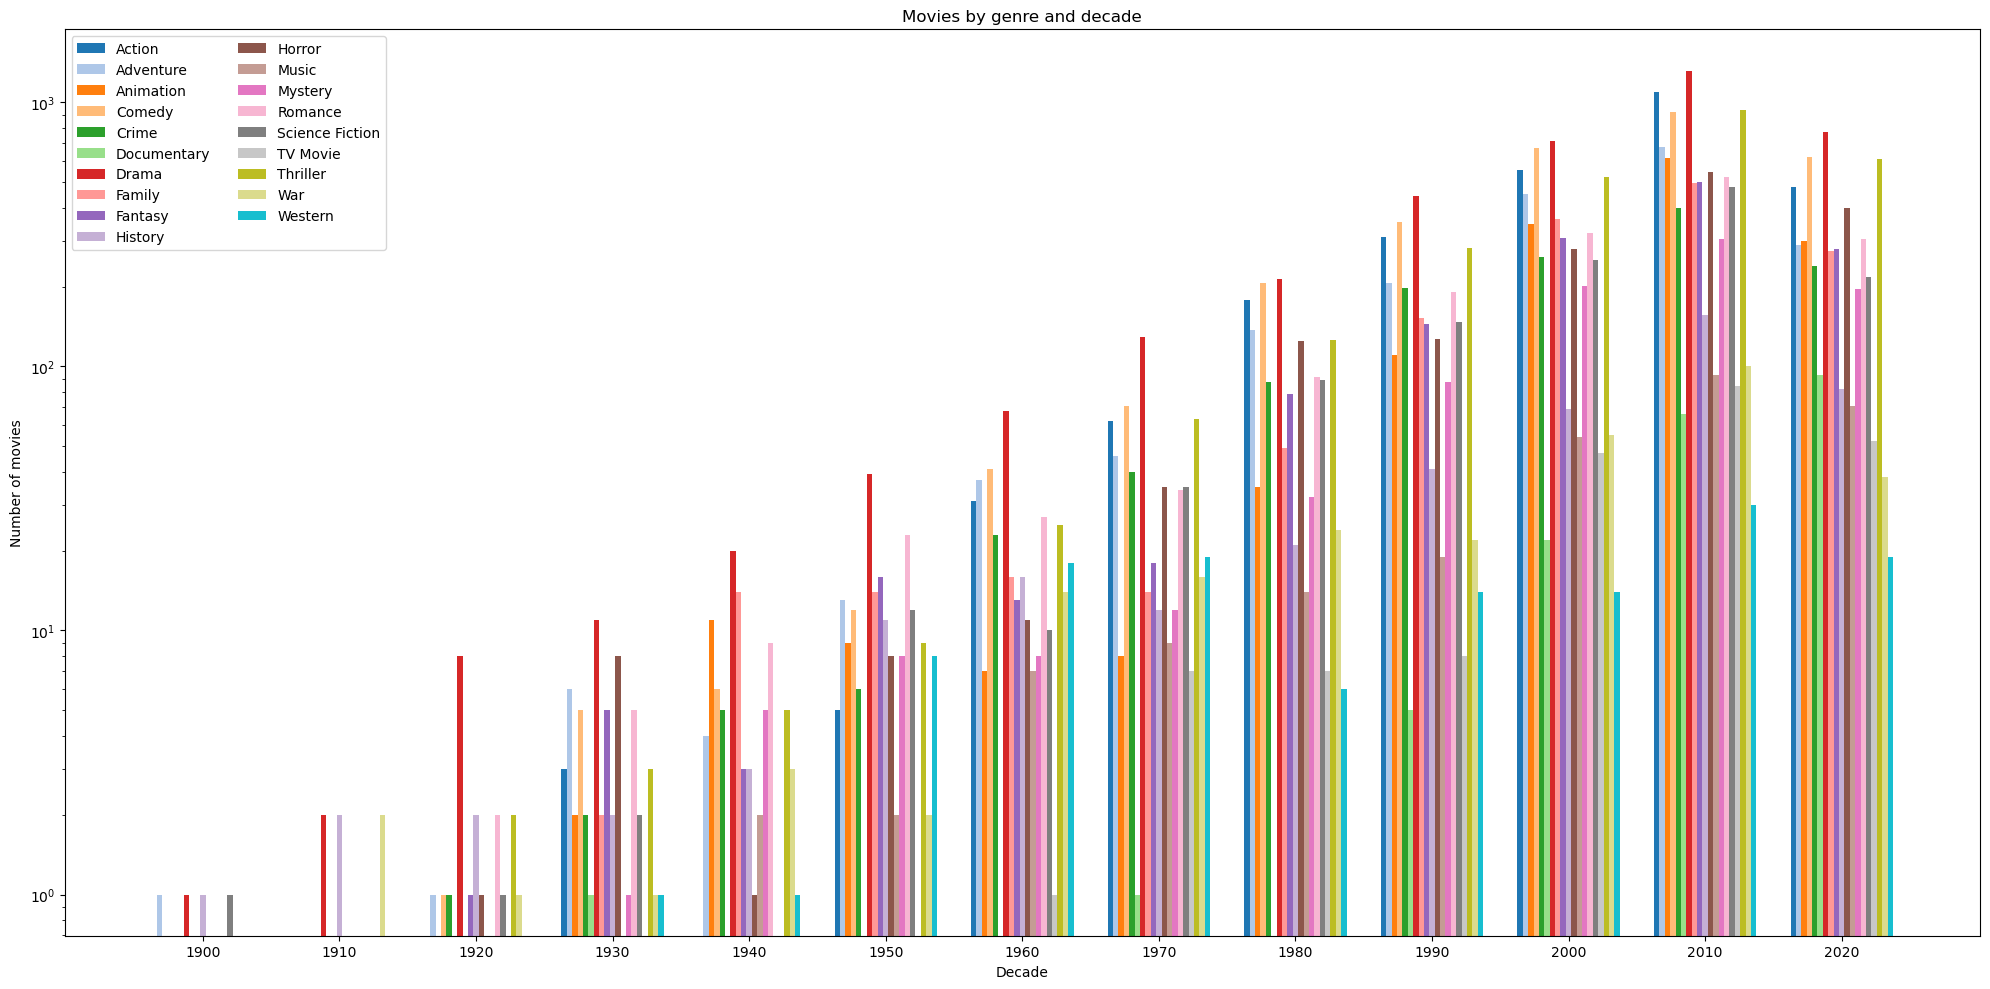

In [ ]:
dataset_genre = dataset.copy()

# Drop description column
dataset_genre = dataset_genre.drop(columns=['overview'])

# Extract year from the release date
dataset_genre['date_x'] = pd.to_datetime(dataset_genre['date_x'])
dataset_genre['year'] = dataset_genre['date_x'].dt.year

# Extract all individual genres from the genre column
all_genres = []
for genre_string in dataset_genre['genre']:
    # Split on comma and remove any non-standard whitespace
    genres = [g.strip() for g in genre_string.split(',')]
    all_genres.extend(genres)

# Get unique genres and sort them
unique_genres = sorted(list(set(all_genres)))
print(f"Found {len(unique_genres)} unique genres")

# Create a new dataframe with a column for each genre
genres = pd.DataFrame(index=dataset_genre.index)
for genre in unique_genres:
    genres[genre] = dataset_genre['genre'].apply(lambda x: 1 if genre in x else 0)

# Join the original dataset with the genre dataframe
dataset_genre = dataset_genre.join(genres)

# Drop unnecessary columns
dataset_genre = dataset_genre.drop(columns=['genre', 'crew', 'names', 'orig_title', 'status', 'orig_lang', 'budget_x', 'score', 'date_x', 'revenue', 'country'])

# Print the first few rows of the dataset
print(dataset_genre.head())
print(dataset_genre.shape)

# Change the year of a movie to the decade it was released in
for row in dataset_genre.itertuples():
    dataset_genre.at[row.Index, 'year'] = row.year - (row.year % 10)


# --- PLOT ---
# Group by decade and sum the genre columns
dataset_genre = dataset_genre.groupby('year').sum()

# Create a colormap for the genres
colormap = plt.cm.tab20

# Plot the data
plt.figure(figsize=(20, 10))
bar_width = 0.75 / len(dataset_genre.columns)
x = np.arange(len(dataset_genre.index))

for i, genre in enumerate(dataset_genre.columns):
    plt.bar(x + i * bar_width, dataset_genre[genre], 
            width=bar_width, label=genre, color=colormap(i % 20))

plt.xticks(x + bar_width * len(dataset_genre.columns) / 2 - bar_width/2, dataset_genre.index)
plt.legend(loc='upper left', ncol=2)
plt.title('Movies by genre and decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')
plt.yscale('log')
plt.tight_layout()
plt.show()

##### Analyysi:
Kaavio on logaritminen. Voidaan päätellä, että ylipäänsä elokuvien määrä on lisääntynyt vuosien saatossa. 2010 -vuonna elokuvia tehtiin noin 1000 -kertainen määrä vuoteen 1900 verrattuna. Myös genrejen kirjo on kasvanut.

#### Mikä näyttelijöiden yhdistelmä tuottaa suosittuja elokuvia?

#### Korrelaatio arvioiden ja tuoton välillä. Voiko elokuva olla huonosti arvioitu mutta silti tuottoisa tai toisin päin?

#### Jos tekisimme elokuvan, millainen sen kannattaa olla, että se on tuottoisa ja suosittu?

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Copy the dataset
dataset_profitable = dataset.copy()

# Drop rows with missing values
dataset_profitable = dataset_profitable.dropna()
dataset_profitable = dataset_profitable[dataset_profitable['score'] != 0.0]

# Extract year from the release date
dataset_profitable['date_x'] = pd.to_datetime(dataset_profitable['date_x'])
dataset_profitable['year'] = dataset_profitable['date_x'].dt.year

# Convert categorical variables to dummy variables
dataset_profitable = pd.get_dummies(dataset_profitable, columns=['genre', 'country', 'orig_lang'], drop_first=True)

# Define the features and target variable
X = dataset_profitable.drop(columns=['names', 'date_x', 'overview', 'crew', 'orig_title', 'status', 'revenue'])
y = dataset_profitable['revenue'] > dataset_profitable['revenue'].mean()

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Logistic Regression Metrics:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))



Logistic Regression Metrics:
Accuracy: 0.8604651162790697
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.89      0.88      1141
        True       0.85      0.82      0.83       837

    accuracy                           0.86      1978
   macro avg       0.86      0.85      0.86      1978
weighted avg       0.86      0.86      0.86      1978

Confusion Matrix:
[[1019  122]
 [ 154  683]]


# Vaihe 5
### Analyysin tulkinta

# Vaihe 6
### Tulosten hyödyntäminen